In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp '/content/drive/My Drive/Academics/CS/AML/Project/Data/davidson.csv' .
!cp '/content/drive/My Drive/Academics/CS/AML/Project/Data/wassem_css.csv' .
!cp '/content/drive/My Drive/Academics/CS/AML/Project/Data/wassem_hovy_naacl.csv' .

In [3]:
import pandas as pd
import numpy as np

## Step 1: load and combine the columns needed from 3 dataset
* only need two columns "tweet text" and "label class" column
* only two classes: hate(including offensive),lable as 1, with the rest labled as 0
* use expert anotation in wassem_data


In [4]:
wassem_data = pd.read_csv("wassem_css.csv",header = 0, sep = "\t")
wassem_data.head()


,Tweet_ID,Previous,User_ID,Text,Expert_Annotation,Amateur_Annotations
0,570775709343461377,5.707751e+17,24414732,@TVBachelor @NewJerzeyBoy what about the femin...,both,"[neither,sexism,sexism]"
1,596730741490253824,5.967300e+17,13857342,@ThelmaSleaze uh... did you watch the video? o...,both,"[neither,racism,sexism]"
2,600800567426883585,NaN,254174483,Managed to hit a bird and a small rodent on my...,both,"[neither,neither,neither]"
3,603546751841230848,NaN,2264363900,"If you believe a #holohoax or #gays, LGBT &amp...",both,"[sexism,both,sexism]"
4,603584564582326272,NaN,2198745044,"Rid yourself of #Feminazi, #Fag &amp; #Jewf. E...",both,"[sexism,sexism,sexism]"


In [5]:
waseem_data2 = pd.read_csv("wassem_hovy_naacl.csv",header = 0, sep = "\t")
waseem_data2.head()

,Tweet_ID,Previous,User_ID,Text,Label
0,567080871472017408,5.670786e+17,2941145694,@truaemusic The followers of the religion give...,racism
1,566098518616449024,5.660874e+17,2941145694,@Love___Egypt @washingtonpost All the land tha...,racism
2,554672350361571328,NaN,2941145694,@CamilleHughes16 @edbarber101658 @_Watch_Obser...,racism
3,569878129772081153,5.698451e+17,2941145694,@KellyTurner99 @brushyblues @buellerishere The...,racism
4,568541747849998337,NaN,2941145694,@buellerishere Who cares. ISIS does what Moham...,racism


In [6]:
davidson_data = pd.read_csv("davidson.csv")
davidson_data.head()
#class 0 /1 stands for hate / offensive; 2 stands for none

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
data1 = wassem_data[["Text","Expert_Annotation"]]
data1.loc[data1["Expert_Annotation"].isin(['both', 'racism', 'sexism']),"IsHate"] = 1
data1.loc[data1["Expert_Annotation"].isin(['neither']),"IsHate"] = 0
data1.drop("Expert_Annotation",axis = 1,inplace = True)
data2 = waseem_data2[["Text","Label"]]
data2.loc[data2["Label"].isin(['racism', 'sexism']),"IsHate"] = 1
data2.loc[data2["Label"].isin(['none']),"IsHate"] = 0
data2.drop("Label",axis = 1,inplace = True)
data3 = davidson_data[["tweet","class"]]
data3.loc[data3["class"].isin([0,1]),"IsHate"] = 1
data3.loc[data3["class"].isin([2]),"IsHate"] = 0
data3 = data3.rename(columns = {"tweet":"Text"})
data3.drop("class",axis = 1, inplace = True)
data_full = pd.concat([data1,data2, data3], ignore_index=True)
print(data_full.shape)
del data1
del data2
del data3
del wassem_data
del waseem_data2
del davidson_data
data_full.head()
data_full.to_csv("/content/drive/My Drive/AML/Project/Data/Merged_Raw_Data.csv",index = False)

(47652, 2)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

## Step 2: prprocess the text 
* get to lower case
* fix the contraction
* remove embedded url
* remove non_ascii words
* remove punctuation
* remove stopwords
* lemmetize words

In [8]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
!pip install contractions
import re, unicodedata
import contractions
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 245kB 6.0MB/s 
     |████████████████████████████████| 317kB 19.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81689 sha256=e6c497828fbb4bb591c6a6eb685a0678adaa2ff00ed68455d716ec633bae8b9d
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [10]:

def to_lowercase(text):
    return text.lower()
def replace_contractions(text):
    return contractions.fix(text)
def remove_URL(text):
    return re.sub(r"http\S+", "", text)
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas
def detokenize_words(words):
    separator = ' '
    return separator.join(words)
def preprocess_text(df, textcol='Text'):
    df[textcol] = df[textcol].apply(to_lowercase)
    df[textcol] = df[textcol].apply(replace_contractions)
    df[textcol] = df[textcol].apply(remove_URL)
    df[textcol] = df[textcol].apply(word_tokenize)
    df[textcol] = df[textcol].apply(remove_non_ascii)
    df[textcol] = df[textcol].apply(remove_punctuation)
    df[textcol] = df[textcol].apply(remove_stopwords)
    df[textcol] = df[textcol].apply(lemmatize_verbs)
    df[textcol] = df[textcol].apply(detokenize_words)
    # return df
preprocess_text(data_full)
data_full.to_csv("/content/drive/My Drive/Academics/CS/AML/Project/Data/preprocessed_full.csv", index = False)



## A bit examine the dataset
* symmetry in data distribution

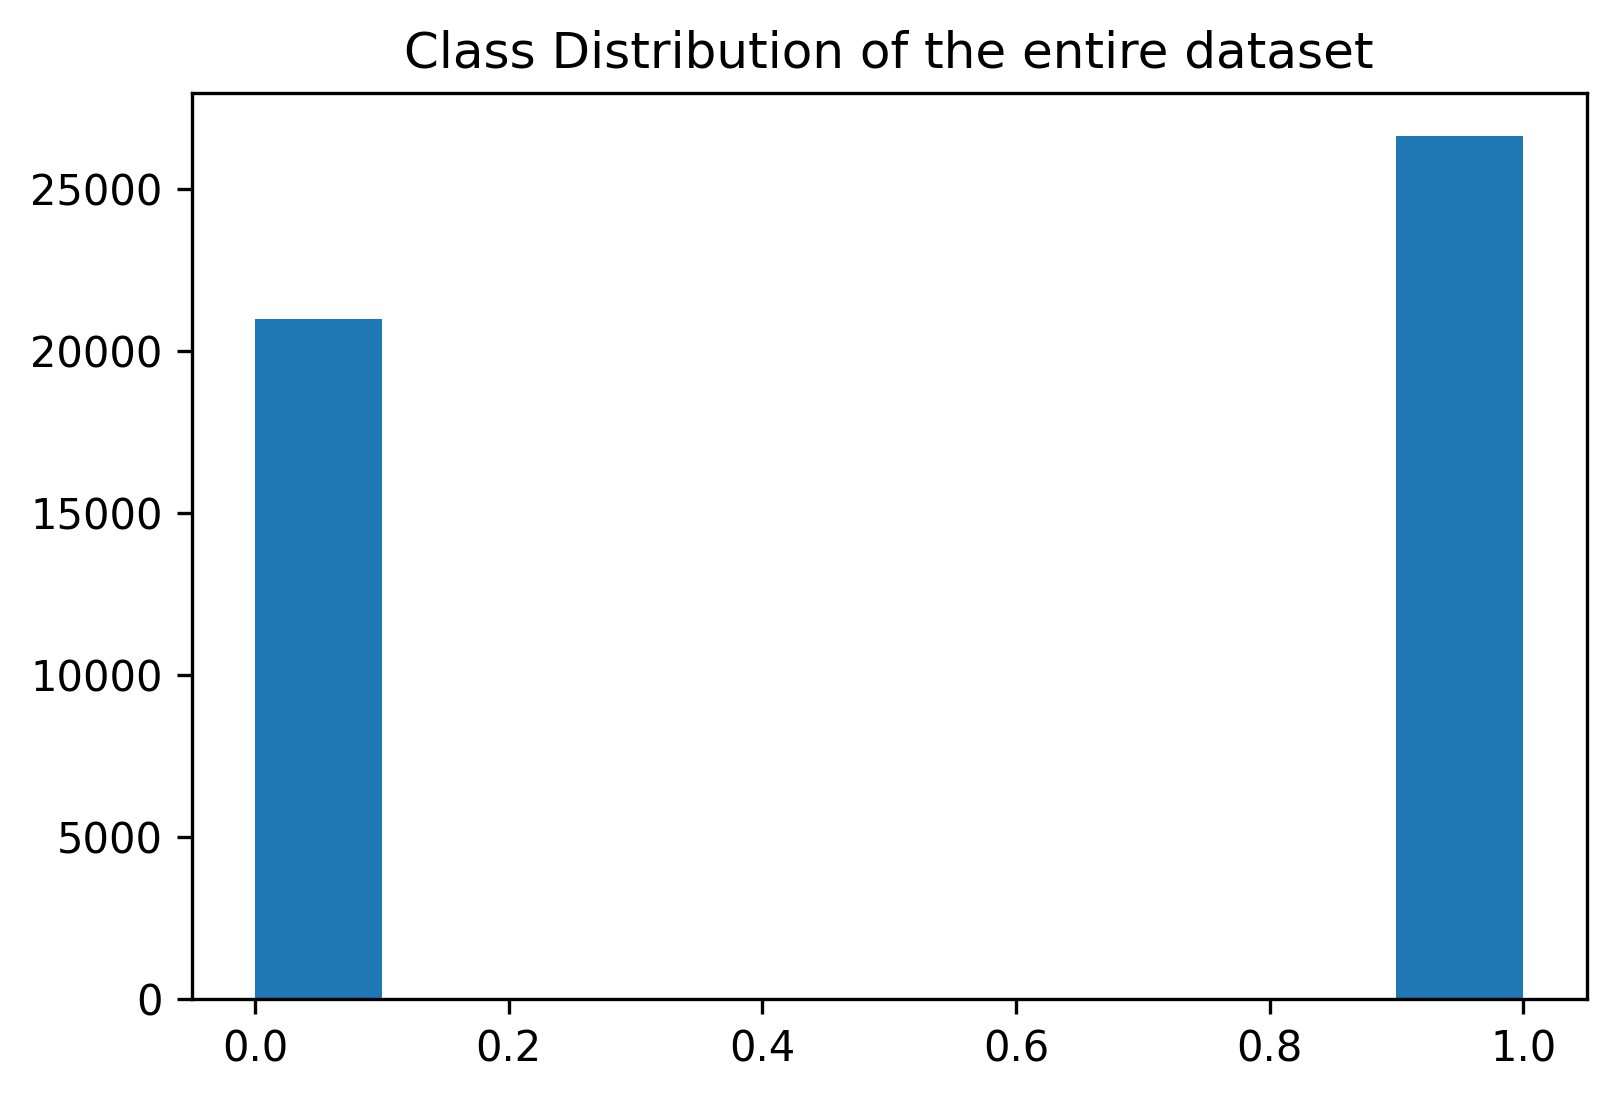

0.5591580626206665


In [11]:
import matplotlib.pyplot as plt
plt.figure(dpi = 300)
plt.hist(data_full["IsHate"])
plt.title("Class Distribution of the entire dataset")
plt.show()
print(len(data_full[data_full["IsHate"] == 1.0]) / len(data_full))

The result suggests that the original dataset we use has pretty even distribution of the hate and non-hate classes of texts, which is favorable in random sampling in model training and makes accuracy one measurement for the model performance.